In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
from src.data import MultiviewImgDataset, IFCNetPly, IFCNetNumpy
from src.models.models import MVCNN, SVCNN, DGCNN, MeshNet
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import transforms
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize

In [3]:
data_root = Path("../data/processed/MVCNN/IFCNetCore")
max_batch_size = 31

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
transform = [
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
transform = transforms.Compose(transform)

train_dataset = MultiviewImgDataset(data_root, class_names, 12, partition="train", transform=transform)
val_dataset = MultiviewImgDataset(data_root, class_names, 12, partition="train", transform=transform)
test_dataset = MultiviewImgDataset(data_root, class_names,12, partition="test", transform=transform)

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, perm[:train_len])
val_dataset = Subset(val_dataset, perm[train_len:])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=max_batch_size, num_workers=8)

In [5]:
model_dir = Path("../models/")
with (model_dir/"MVCNNParams.json").open("r") as f:
    config = json.load(f)

svcnn = SVCNN(nclasses=len(class_names), pretrained=config["pretrained"], cnn_name=config["cnn_name"])
model = MVCNN(svcnn, nclasses=len(class_names), num_views=12, cnn_name=config["cnn_name"])
model_state, _ = torch.load(model_dir/"MVCNNWeights+Optimizer")
model.load_state_dict(model_state)

<All keys matched successfully>

In [6]:
device = torch.device("cuda")
model.to(device)

MVCNN(
  (net_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [7]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data, labels in tqdm(loader):
            data, labels = data.to(device), labels.to(device)
            data = data.view(-1, *data.shape[-3:])

            outputs = model(data)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    print(result)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
count_parameters(model)

128848276

In [ ]:
eval(model, train_loader, device, class_names)

In [ ]:
eval(model, val_loader, device, class_names)

100%|██████████| 77/77 [00:39<00:00,  1.95it/s]


{'accuracy_score': 0.869693148381673, 'balanced_accuracy_score': 0.8554361052525193, 'precision_score': 0.8747509814545653, 'recall_score': 0.869693148381673, 'f1_score': 0.8693084700684225}


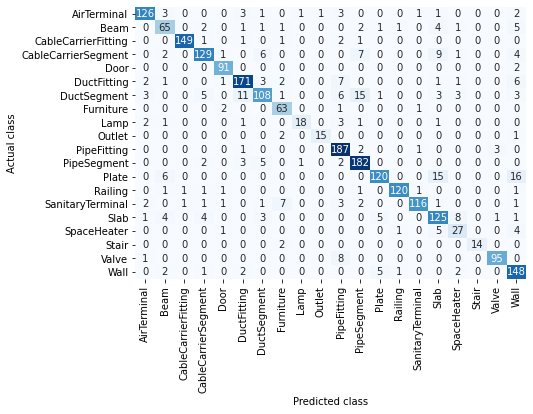

In [8]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/mvcnn_confusion.png")

In [ ]:
np.savez("MVCNNProbs.npz", labels=test_labels, probs=test_probs)

In [9]:
data, labels = next(iter(train_loader))
data = data.to(device)
dummy_input = data.view(-1, *data.shape[-3:])

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 1000
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)
print(std_syn)

17.67763258457184
0.07009676121378322


In [8]:
data, labels = next(iter(test_loader))
data = data.to(device)
dummy_input = data.view(-1, *data.shape[-3:])

repetitions=100
total_time = 0
with torch.no_grad():
    for rep in range(repetitions):
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        starter.record()
        _ = model(dummy_input)
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)/1000
        total_time += curr_time
Throughput =   (repetitions*max_batch_size)/total_time
print('Final Throughput:',Throughput)

Final Throughput: 69.28531106233282


In [ ]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]

In [ ]:
wrong_pred_dir = Path("../data/external/MVCNN/wrong_classes/IFCNetCore")
raw_data_dict = {path.stem: path for path in Path("../data/raw/IFCNetCore").glob("**/test/*.obj")}
wrong_pred_dir.mkdir(parents=True, exist_ok=True)
for i in wrong_predictions:
    label_str = class_names[test_labels[i]]
    prediction_str = class_names[test_predictions[i]]
    print(f"{test_dataset.filepaths[i][0].stem[:-2]}, Label: {label_str}, Prediction: {prediction_str}")
    target_dir = wrong_pred_dir / label_str
    target_dir.mkdir(exist_ok=True)
    filename = test_dataset.filepaths[i][0]
    shutil.copy(str(raw_data_dict[filename.stem[:-2]]), str(target_dir / f"{filename.stem[:-2]}_{prediction_str}.obj"))